### Final Modeling

Final model to include these features: 

FINAL MODEL: 
- Staggered over JUST 2 years
- over 15 years? 
- Features -- Global nickel production

NEXT STEPS to include:
- Fixing input data for global prod 
- Running model and evaluating results 
- Constructing CONFIDENCE INTERVALS OF RESULTS
- Final graphs of predictions


- OUTPUT CSV which includes timestamp of predictions 
- Check MAE over previous 3 years

### Additional Features: 
df['week_of_year'] = df.index.weekofyear 
df['day_of_month'] = df.index.day

GDP per capita and GDP Growth - China https://data.worldbank.org/indicator/NY.GDP.PCAP.CD?locations=CN


In [45]:
import pandas as pd
from matplotlib import pyplot as plt
import re

from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import numpy as np
import fbprophet
from fbprophet import Prophet
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from pylab import rcParams
import datetime

import logging

from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.linear_model import LinearRegression

from sklearn import metrics

from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import Ridge


logging.getLogger().setLevel(logging.ERROR)
from sklearn.preprocessing import PolynomialFeatures

from sklearn import neighbors
from sklearn.ensemble import AdaBoostRegressor

from sqlalchemy import create_engine
from sqlalchemy import(Table, Column, String, Integer, Boolean)
from sqlalchemy import MetaData, Table

from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

import os

from sklearn.utils import resample
import numpy as np


In [46]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=4).mean()
    rolstd =  pd.Series(timeseries).rolling(window=4).std()
#Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    # dftest = adfuller(timeseries, autolag='AIC')
    dftest = adfuller(timeseries)
    
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

LME_futures = pd.read_excel('forecasting_raw_data/LME Futures Price.xlsx')
LME_futures = LME_futures.iloc[3:, 1:]
#LME_futures['Unnamed: 1'] = pd.datetime(LME_futures['Unnamed: 1'])
LME_futures.index = LME_futures['Unnamed: 1']



LME_futures = LME_futures.iloc[:, 1:]
#LME_futures = LME_futures[LME_futures.index.year>=2000]
LME_futures.isnull().sum()

LME = LME_futures.iloc[:, 0]
LME = LME.astype(float)
LME = LME.resample('B').mean()

inventory = LME_futures.iloc[:, 1]
inventory = inventory.astype(float)
inventory = inventory.resample('B').mean()



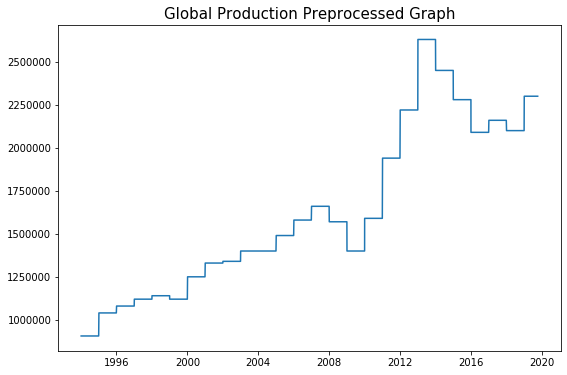

In [47]:
global_production = pd.read_excel('forecasting_raw_data/nickel_features/nickel_extracted.xlsx')
date_index = [datetime.datetime(year, 1, 1) for year in range(1994, 2021)]
series = list(global_production.iloc[:, 1])
series.append(np.nan)

global_production = pd.DataFrame({'global_prod': series})
global_production.index = date_index


global_production = global_production.resample('B').ffill()
upsampled_prod = global_production.interpolate(method='linear')

upsampled_prod = upsampled_prod.dropna()
upsampled_prod = upsampled_prod.loc[:LME.index[-1], :]

LME = LME[upsampled_prod.index]
plt.plot(upsampled_prod)
plt.title('Global Production Preprocessed Graph', fontsize=15)
plt.show()

In [48]:


china_gdp = pd.read_csv('forecasting_raw_data/nickel_features/china_gdp_by_quarter.csv')
china_gdp = china_gdp.set_index(pd.to_datetime(china_gdp['DATE']))
china_gdp = china_gdp.iloc[:, 1]

#china_gdp = china_gdp.reindex(LME.index)
china_gdp = china_gdp.resample('B').ffill()
upsampled = china_gdp.interpolate(method='linear')

upsampled
#LME = LME[upsampled.index]


DATE
1992-01-01    5.262800e+11
1992-01-02    5.262800e+11
1992-01-03    5.262800e+11
1992-01-06    5.262800e+11
1992-01-07    5.262800e+11
1992-01-08    5.262800e+11
1992-01-09    5.262800e+11
1992-01-10    5.262800e+11
1992-01-13    5.262800e+11
1992-01-14    5.262800e+11
1992-01-15    5.262800e+11
1992-01-16    5.262800e+11
1992-01-17    5.262800e+11
1992-01-20    5.262800e+11
1992-01-21    5.262800e+11
1992-01-22    5.262800e+11
1992-01-23    5.262800e+11
1992-01-24    5.262800e+11
1992-01-27    5.262800e+11
1992-01-28    5.262800e+11
1992-01-29    5.262800e+11
1992-01-30    5.262800e+11
1992-01-31    5.262800e+11
1992-02-03    5.262800e+11
1992-02-04    5.262800e+11
1992-02-05    5.262800e+11
1992-02-06    5.262800e+11
1992-02-07    5.262800e+11
1992-02-10    5.262800e+11
1992-02-11    5.262800e+11
                  ...     
2019-02-19    2.134330e+13
2019-02-20    2.134330e+13
2019-02-21    2.134330e+13
2019-02-22    2.134330e+13
2019-02-25    2.134330e+13
2019-02-26    2.134330e

In [49]:
# List of series  


listOfSeries = [pd.Series(['Raju', 21, 'Bangalore', 'India'], index=dfObj.columns ) ,
pd.Series(['Sam', 22, 'Tokyo', 'Japan'], index=dfObj.columns ) ,
pd.Series(['Rocky', 23, 'Las Vegas', 'US'], index=dfObj.columns ) ]

china_gdp.append(listOfSeries)

NameError: name 'dfObj' is not defined

In [50]:
## Different version of China gdp

china_gdp_per_cap = pd.read_excel('forecasting_raw_data/nickel_features/china_gdp_summary.xlsx')
china_gdp_per_cap.columns = china_gdp_per_cap.iloc[0, :]

china_gdp_per_cap.iloc[1, 1990: ]

china_gdp_per_cap

,Country Name,Country Code,Indicator Name,Indicator Code,1960.0,1961.0,1962.0,1963.0,1964.0,1965.0,...,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0
0,Country Name,Country Code,Indicator Name,Indicator Code,1960.000000,1961.000000,1962.000000,1963.000000,1964.000000,1965.000000,...,2010.000000,2011.000000,2012.000000,2013.000000,2014.000000,2015.000000,2016.000000,2017.000000,2018.000000,2019.0
1,China,CHN,GDP per capita (current US$),NY.GDP.PCAP.CD,89.520542,75.805838,70.909412,74.313643,85.498555,98.486778,...,4550.453596,5618.132491,6316.918863,7050.645920,7651.366044,8033.388043,8078.790474,8759.041578,9770.847088,NaN
2,China,CHN,GDP per capita growth (annual %),NY.GDP.PCAP.KD.ZG,NaN,-26.527644,-6.351505,7.622254,15.468995,14.197889,...,10.103101,9.027256,7.335380,7.237863,6.757622,6.363469,6.160281,6.161772,6.115117,NaN


In [51]:
upsampled_prod.tail()

,global_prod
2019-10-01,2300000.0
2019-10-02,2300000.0
2019-10-03,2300000.0
2019-10-04,2300000.0
2019-10-07,2300000.0


### Note About Preprocessing: 

#### For differenced data, to unscale, must concatenate the LAST VALUE OF THE ORIGINAL Y OF THE TRAINING SET, with the new PREDICTED SERIES OF SCALED_YHAT to use CUMSUM()

In [52]:
def preprocess(series, window_setting):
    moving_avg = series.rolling(window=window_setting).mean().shift()
    moving_avg_diff = series-moving_avg
    return moving_avg_diff

    

In [53]:
'''Returns unscaled y values BUT MUST ASSIGN INDEX AFTER FUNCTION! '''
def unscale(series, original_tail, window_setting):
    unscaled = []
    for key, item in series.items():
        rolling_avg = original_tail.tail(window_setting).mean()
        unscaled_result = item+rolling_avg
        original_tail = original_tail.append(pd.Series([unscaled_result]))
        unscaled.append(unscaled_result)
        
    unscaled = pd.Series(unscaled)
    unscaled = unscaled
    return unscaled

LME_shifted = LME.shift(-261).dropna()


#### Take Out Trend

Pandas time series resampling options
https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html

In [54]:

# Rolling Average from last 8 weeks
window_setting= 5*4
LME_stationary = preprocess(LME, window_setting)
inventory_stationary=preprocess(inventory, window_setting)
upsampled_stationary = preprocess(upsampled, window_setting)
global_prod_stationary = preprocess(upsampled_prod, window_setting)


rcParams['figure.figsize'] = 9, 6

list_one = list(LME_stationary.index)
list_two = list(LME_stationary)
df = pd.DataFrame(list(zip(list_one, list_two)), columns = ['ds', 'lag0'])
df.head()

# How many lag periods? - LAG DAYS
lag_length = 20

df['lag1'] = df.lag0.shift(periods=1*lag_length)
df['lag2'] = df.lag0.shift(periods=2*lag_length)
df['lag3'] = df.lag0.shift(periods=3*lag_length)
df['lag4'] = df.lag0.shift(periods=4*lag_length)
df['lag5'] = df.lag0.shift(periods=5*lag_length)

df['lag6'] = df.lag0.shift(periods=6*lag_length)
df['lag7'] = df.lag0.shift(periods=7*lag_length)
df['lag8'] = df.lag0.shift(periods=8*lag_length)
df['lag9'] = df.lag0.shift(periods=9*lag_length)
df['lag10'] = df.lag0.shift(periods=10*lag_length)

df['lag11'] = df.lag0.shift(periods=11*lag_length)
df['lag12'] = df.lag0.shift(periods=13*lag_length)
df['lag13'] = df.lag0.shift(periods=15*lag_length)
df['lag14'] = df.lag0.shift(periods=17*lag_length)
df['lag15'] = df.lag0.shift(periods=19*lag_length)
df['lag16'] = df.lag0.shift(periods=21*lag_length)
df['lag17'] = df.lag0.shift(periods=23*lag_length)
'''
df['lag18'] = df.lag0.shift(periods=26*lag_length)
df['lag19'] = df.lag0.shift(periods=29*lag_length)
df['lag20'] = df.lag0.shift(periods=32*lag_length)

df['lag21'] = df.lag0.shift(periods=35*lag_length)
df['lag22'] = df.lag0.shift(periods=38*lag_length)
'''

df.index = df['ds']
df = df.iloc[:, 1:]
#df['gdp'] = upsampled_stationary
df['global_prod'] = global_prod_stationary
df['week_of_year'] = df.index.weekofyear 
df['day_of_month'] = df.index.day


df['y'] = df['lag0'].shift(-261)
df = df.dropna(subset=['global_prod', 'lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12', 'lag13', 'lag14', 'lag15', 'lag16', 'lag17'])

#df = df.dropna()
df.tail()

,lag0,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,...,lag12,lag13,lag14,lag15,lag16,lag17,global_prod,week_of_year,day_of_month,y
ds,,,,,,,,,,,,,,,,,,,,,
2019-10-01,-199.825,1990.075,865.850,503.7625,-144.525,-331.700,-132.5625,56.7375,270.800,397.600,...,-74.775,147.9625,168.0625,808.450,63.325,710.975,0.0,40,1,NaN
2019-10-02,35.625,1828.125,608.975,743.2875,-189.275,-37.925,-177.9875,105.2125,467.200,473.325,...,179.175,367.1625,542.4875,1820.150,263.875,647.850,0.0,40,2,NaN
2019-10-03,189.375,1167.475,1557.275,829.7375,-164.225,32.825,-387.5875,-119.4375,355.200,510.975,...,-111.300,194.5375,146.6875,1526.250,241.000,864.925,0.0,40,3,NaN
2019-10-04,307.375,1311.925,1087.725,1100.6875,-112.525,-141.575,-371.4375,-134.1875,441.250,659.275,...,22.875,141.7875,9.6125,1187.525,170.775,1213.175,0.0,40,4,NaN
2019-10-07,203.225,1559.425,1149.550,1205.3125,-206.025,-140.275,-355.6875,-165.5625,371.325,450.275,...,-34.025,-132.4875,-227.3375,525.850,322.050,1139.375,0.0,41,7,NaN


### Splitting up Training/Testing by Day

- Train multiple models on 261*16=4176 days versus Tests of 261 AND 522 days (1 and 2 years)

How to normalize/standardize: 
https://machinelearningmastery.com/rescaling-data-for-machine-learning-in-python-with-scikit-learn/

### GOAL: To run tests over last 5??? years to take a closer look at MAE's over different sliding windows 

In [53]:
dates = df.index

In [54]:
np.sqrt(261*15)

62.56996084384263

In [55]:
df.index

DatetimeIndex(['1997-11-03', '1997-11-04', '1997-11-05', '1997-11-06',
               '1997-11-07', '1997-11-10', '1997-11-11', '1997-11-12',
               '1997-11-13', '1997-11-14',
               ...
               '2018-12-19', '2018-12-20', '2018-12-21', '2018-12-24',
               '2018-12-25', '2018-12-26', '2018-12-27', '2018-12-28',
               '2018-12-31', '2019-01-01'],
              dtype='datetime64[ns]', name='ds', length=5522, freq=None)

In [71]:
results = []
datelist = []
paramlist = []

for item in dates[dates<datetime.datetime(2001, 12, 28)]:
    start_date = item
    train_offset = pd.tseries.offsets.BusinessDay(n=15*261)
    end_date = item+train_offset
    
    
    start_date_test = end_date + pd.tseries.offsets.BusinessDay(n=1)
    test_offset = pd.tseries.offsets.BusinessDay(n=261)
    end_date_test = start_date_test+test_offset
    
    train = df.loc[start_date:end_date, :]    
    test = df.loc[start_date_test:end_date_test, :]
    
    

    
    X_train = train[['global_prod', 'lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12', 'lag13', 'lag14', 'lag15', 'lag16', 'lag17']]
    X_test = test[['global_prod', 'lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12', 'lag13', 'lag14', 'lag15', 'lag16', 'lag17']]

    y_train = train['y']
    y_test = test['y']

    X_train = preprocessing.normalize(X_train)
    X_test = preprocessing.normalize(X_test)
    
    #X_train = preprocessing.scale(X_train)
    #X_test = preprocessing.scale(X_test)
    
    scalerX = StandardScaler()
    X_train = scalerX.fit_transform(X_train)
    X_test = scalerX.transform(X_test)
    
    
    cv_results={}

    
    for K in range(0, 60, 2):
        K = K+1
        regressor = neighbors.KNeighborsRegressor(n_neighbors=K)

        #rint()
        #rint('K: ', K)

        regressor.fit(X_train, y_train)
        #print(regressor.coef_)

        y_pred = regressor.predict(X_test)
        y_pred = pd.Series(y_pred)
        y_pred.index = y_test.index


        original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

        for key, item in y_pred.items():
            rolling_avg = original_tail.tail(window_setting).mean()
            unscaled_result = item+rolling_avg
            original_tail = original_tail.append(pd.Series([unscaled_result]))

        unscaled = pd.Series(original_tail)
        unscaled = unscaled[window_setting:]
        unscaled.index = y_test.index
        
        original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

        for key, item in y_test.items():
            rolling_avg = original_tail.tail(window_setting).mean()
            original_y = item+rolling_avg
            original_tail = original_tail.append(pd.Series([original_y]))


        original_y = pd.Series(original_tail)
        original_y = original_y[window_setting:]
        original_y.index = y_test.index

        mae = metrics.mean_absolute_error(original_y, unscaled)

        #print('kfold test accuracy =', kfold_test_accuracy)
        cv_results[str(K)] = mae

        
    
    cv_results_series = pd.Series(list(cv_results.values()))
    cv_results_series.index = cv_results.keys()
    min_test_accuracy = cv_results_series.min()
    min_parameters = cv_results_series.idxmin()
    
        
    print(start_date_test,', Optimal K:' , min_parameters, ', MAE:',min_test_accuracy )
    #or key, value in cv_results.items():
        #rint(key, value)
    results.append(min_test_accuracy)
    datelist.append(start_date_test)
    paramlist.append(min_parameters)

    

2011-12-30 00:00:00 , Optimal K: 53 , MAE: 4294.048872724503
2012-01-02 00:00:00 , Optimal K: 53 , MAE: 4250.235988973795
2012-01-03 00:00:00 , Optimal K: 53 , MAE: 4210.335273524048
2012-01-04 00:00:00 , Optimal K: 53 , MAE: 4250.122340954941
2012-01-05 00:00:00 , Optimal K: 53 , MAE: 4255.803154533861
2012-01-06 00:00:00 , Optimal K: 53 , MAE: 4238.434095955146
2012-01-09 00:00:00 , Optimal K: 53 , MAE: 4208.956101400772
2012-01-10 00:00:00 , Optimal K: 53 , MAE: 4198.840088617709
2012-01-11 00:00:00 , Optimal K: 53 , MAE: 4221.969296433308
2012-01-12 00:00:00 , Optimal K: 53 , MAE: 4235.792519342897
2012-01-13 00:00:00 , Optimal K: 53 , MAE: 4271.146516420104
2012-01-16 00:00:00 , Optimal K: 53 , MAE: 4270.130253248866
2012-01-17 00:00:00 , Optimal K: 53 , MAE: 4298.400047810215
2012-01-18 00:00:00 , Optimal K: 53 , MAE: 4299.072430634236
2012-01-19 00:00:00 , Optimal K: 53 , MAE: 4318.471718304738
2012-01-20 00:00:00 , Optimal K: 53 , MAE: 4332.9920163096895
2012-01-23 00:00:00 , O

2012-07-06 00:00:00 , Optimal K: 59 , MAE: 1547.7941248480975
2012-07-09 00:00:00 , Optimal K: 59 , MAE: 1544.9721838733813
2012-07-10 00:00:00 , Optimal K: 59 , MAE: 1544.652650640318
2012-07-11 00:00:00 , Optimal K: 59 , MAE: 1555.4923212230017
2012-07-12 00:00:00 , Optimal K: 59 , MAE: 1566.4349851135878
2012-07-13 00:00:00 , Optimal K: 59 , MAE: 1580.9590019266395
2012-07-16 00:00:00 , Optimal K: 59 , MAE: 1595.1126921179978
2012-07-17 00:00:00 , Optimal K: 59 , MAE: 1605.838687221354
2012-07-18 00:00:00 , Optimal K: 59 , MAE: 1617.3803268317492
2012-07-19 00:00:00 , Optimal K: 59 , MAE: 1624.4580466805082
2012-07-20 00:00:00 , Optimal K: 59 , MAE: 1628.0753054900306
2012-07-23 00:00:00 , Optimal K: 59 , MAE: 1640.9866445260473
2012-07-24 00:00:00 , Optimal K: 59 , MAE: 1654.2299504823661
2012-07-25 00:00:00 , Optimal K: 59 , MAE: 1672.1534925663627
2012-07-26 00:00:00 , Optimal K: 59 , MAE: 1681.2173820267046
2012-07-27 00:00:00 , Optimal K: 59 , MAE: 1690.3589150963658
2012-07-30

2013-01-10 00:00:00 , Optimal K: 59 , MAE: 3681.2959422931353
2013-01-11 00:00:00 , Optimal K: 59 , MAE: 3697.5875288440607
2013-01-14 00:00:00 , Optimal K: 59 , MAE: 3718.360501851775
2013-01-15 00:00:00 , Optimal K: 59 , MAE: 3714.3932754757816
2013-01-16 00:00:00 , Optimal K: 59 , MAE: 3726.929802514833
2013-01-17 00:00:00 , Optimal K: 59 , MAE: 3706.414341482603
2013-01-18 00:00:00 , Optimal K: 59 , MAE: 3657.672226891074
2013-01-21 00:00:00 , Optimal K: 59 , MAE: 3598.452940440504
2013-01-22 00:00:00 , Optimal K: 59 , MAE: 3490.7199072871563
2013-01-23 00:00:00 , Optimal K: 59 , MAE: 3383.6134916912933
2013-01-24 00:00:00 , Optimal K: 59 , MAE: 3270.138460289155
2013-01-25 00:00:00 , Optimal K: 57 , MAE: 3207.1542018776377
2013-01-28 00:00:00 , Optimal K: 57 , MAE: 3193.376267184058
2013-01-29 00:00:00 , Optimal K: 59 , MAE: 3169.180876551645
2013-01-30 00:00:00 , Optimal K: 59 , MAE: 3206.092438058266
2013-01-31 00:00:00 , Optimal K: 59 , MAE: 3299.2549303289497
2013-02-01 00:00:

2013-07-17 00:00:00 , Optimal K: 37 , MAE: 5260.240520021637
2013-07-18 00:00:00 , Optimal K: 27 , MAE: 5315.62761568207
2013-07-19 00:00:00 , Optimal K: 25 , MAE: 5270.605230873613
2013-07-22 00:00:00 , Optimal K: 29 , MAE: 5235.744929007813
2013-07-23 00:00:00 , Optimal K: 29 , MAE: 5286.021381206465
2013-07-24 00:00:00 , Optimal K: 29 , MAE: 5290.2258085728145
2013-07-25 00:00:00 , Optimal K: 31 , MAE: 5317.406041286897
2013-07-26 00:00:00 , Optimal K: 29 , MAE: 5347.332833219467
2013-07-29 00:00:00 , Optimal K: 29 , MAE: 5231.126614862064
2013-07-30 00:00:00 , Optimal K: 33 , MAE: 5122.064061131321
2013-07-31 00:00:00 , Optimal K: 27 , MAE: 5087.586265074649
2013-08-01 00:00:00 , Optimal K: 3 , MAE: 4862.403600576716
2013-08-02 00:00:00 , Optimal K: 29 , MAE: 4765.338176017181
2013-08-05 00:00:00 , Optimal K: 25 , MAE: 4661.181630528261
2013-08-06 00:00:00 , Optimal K: 25 , MAE: 4527.437485005712
2013-08-07 00:00:00 , Optimal K: 5 , MAE: 4489.228587073036
2013-08-08 00:00:00 , Opti

2014-01-22 00:00:00 , Optimal K: 1 , MAE: 1188.592904834826
2014-01-23 00:00:00 , Optimal K: 1 , MAE: 1183.4455874570547
2014-01-24 00:00:00 , Optimal K: 1 , MAE: 1173.6102181973938
2014-01-27 00:00:00 , Optimal K: 21 , MAE: 1243.4564098790763
2014-01-28 00:00:00 , Optimal K: 21 , MAE: 1301.2295433392044
2014-01-29 00:00:00 , Optimal K: 21 , MAE: 1374.404283076331
2014-01-30 00:00:00 , Optimal K: 21 , MAE: 1468.2443760106637
2014-01-31 00:00:00 , Optimal K: 33 , MAE: 1657.6695688329646
2014-02-03 00:00:00 , Optimal K: 33 , MAE: 1838.027305854192
2014-02-04 00:00:00 , Optimal K: 43 , MAE: 2022.3478332786071
2014-02-05 00:00:00 , Optimal K: 45 , MAE: 2144.6189986011304
2014-02-06 00:00:00 , Optimal K: 53 , MAE: 2261.717072864895
2014-02-07 00:00:00 , Optimal K: 55 , MAE: 2381.633177146436
2014-02-10 00:00:00 , Optimal K: 55 , MAE: 2471.223553338386
2014-02-11 00:00:00 , Optimal K: 55 , MAE: 2524.158061236509
2014-02-12 00:00:00 , Optimal K: 57 , MAE: 2526.159411704675
2014-02-13 00:00:00

2014-07-29 00:00:00 , Optimal K: 35 , MAE: 1477.1507080439635
2014-07-30 00:00:00 , Optimal K: 35 , MAE: 1508.1916102612456
2014-07-31 00:00:00 , Optimal K: 35 , MAE: 1547.9990510012806
2014-08-01 00:00:00 , Optimal K: 35 , MAE: 1583.325909871888
2014-08-04 00:00:00 , Optimal K: 35 , MAE: 1632.228486950314
2014-08-05 00:00:00 , Optimal K: 35 , MAE: 1682.8830378599475
2014-08-06 00:00:00 , Optimal K: 35 , MAE: 1733.2973564780596
2014-08-07 00:00:00 , Optimal K: 35 , MAE: 1785.4035677828435
2014-08-08 00:00:00 , Optimal K: 37 , MAE: 1829.5518026535321
2014-08-11 00:00:00 , Optimal K: 35 , MAE: 1838.6840078465495
2014-08-12 00:00:00 , Optimal K: 35 , MAE: 1888.1640528981723
2014-08-13 00:00:00 , Optimal K: 35 , MAE: 1925.2735430809641
2014-08-14 00:00:00 , Optimal K: 35 , MAE: 1992.193325021
2014-08-15 00:00:00 , Optimal K: 37 , MAE: 2025.6108802515873
2014-08-18 00:00:00 , Optimal K: 37 , MAE: 2064.021753021417
2014-08-19 00:00:00 , Optimal K: 35 , MAE: 2111.394124547097
2014-08-20 00:00

2015-02-02 00:00:00 , Optimal K: 25 , MAE: 5138.963131205296
2015-02-03 00:00:00 , Optimal K: 35 , MAE: 5141.925162448233
2015-02-04 00:00:00 , Optimal K: 35 , MAE: 5099.626901784429
2015-02-05 00:00:00 , Optimal K: 37 , MAE: 5076.613916685483
2015-02-06 00:00:00 , Optimal K: 37 , MAE: 5128.046722721876
2015-02-09 00:00:00 , Optimal K: 37 , MAE: 5176.061471799152
2015-02-10 00:00:00 , Optimal K: 39 , MAE: 5239.838220549327
2015-02-11 00:00:00 , Optimal K: 37 , MAE: 5366.168494289373
2015-02-12 00:00:00 , Optimal K: 41 , MAE: 5506.210909477458
2015-02-13 00:00:00 , Optimal K: 39 , MAE: 5596.519629461146
2015-02-16 00:00:00 , Optimal K: 41 , MAE: 5569.619039004497
2015-02-17 00:00:00 , Optimal K: 41 , MAE: 5547.049571286062
2015-02-18 00:00:00 , Optimal K: 39 , MAE: 5522.595224927719
2015-02-19 00:00:00 , Optimal K: 41 , MAE: 5499.97022427562
2015-02-20 00:00:00 , Optimal K: 41 , MAE: 5412.2835404881125
2015-02-23 00:00:00 , Optimal K: 39 , MAE: 5265.132168276747
2015-02-24 00:00:00 , Op

2015-08-07 00:00:00 , Optimal K: 59 , MAE: 1833.5188610070031
2015-08-10 00:00:00 , Optimal K: 59 , MAE: 1816.958536279908
2015-08-11 00:00:00 , Optimal K: 59 , MAE: 1785.0380167101864
2015-08-12 00:00:00 , Optimal K: 59 , MAE: 1758.283901617421
2015-08-13 00:00:00 , Optimal K: 59 , MAE: 1751.5313544780295
2015-08-14 00:00:00 , Optimal K: 59 , MAE: 1795.8149748308692
2015-08-17 00:00:00 , Optimal K: 59 , MAE: 1821.5890753227784
2015-08-18 00:00:00 , Optimal K: 59 , MAE: 1866.4880371049148
2015-08-19 00:00:00 , Optimal K: 59 , MAE: 1912.1783804191018
2015-08-20 00:00:00 , Optimal K: 59 , MAE: 1945.081377436418
2015-08-21 00:00:00 , Optimal K: 59 , MAE: 1972.6725198825716
2015-08-24 00:00:00 , Optimal K: 59 , MAE: 2021.2908478419222
2015-08-25 00:00:00 , Optimal K: 59 , MAE: 2066.0148349698457
2015-08-26 00:00:00 , Optimal K: 59 , MAE: 2135.8853817647782
2015-08-27 00:00:00 , Optimal K: 59 , MAE: 2216.189761583858
2015-08-28 00:00:00 , Optimal K: 59 , MAE: 2289.7757437495115
2015-08-31 0

2016-02-11 00:00:00 , Optimal K: 59 , MAE: 1649.775431405796
2016-02-12 00:00:00 , Optimal K: 59 , MAE: 1565.0520851231497
2016-02-15 00:00:00 , Optimal K: 59 , MAE: 1474.0193002531378
2016-02-16 00:00:00 , Optimal K: 59 , MAE: 1391.2257565317473
2016-02-17 00:00:00 , Optimal K: 59 , MAE: 1302.7131583988303
2016-02-18 00:00:00 , Optimal K: 59 , MAE: 1210.2286088356486
2016-02-19 00:00:00 , Optimal K: 59 , MAE: 1123.9851075764166
2016-02-22 00:00:00 , Optimal K: 59 , MAE: 1071.1746097452556
2016-02-23 00:00:00 , Optimal K: 59 , MAE: 1049.304471195689
2016-02-24 00:00:00 , Optimal K: 59 , MAE: 1025.7124728563765
2016-02-25 00:00:00 , Optimal K: 49 , MAE: 1020.1144031589993
2016-02-26 00:00:00 , Optimal K: 49 , MAE: 955.8587886357423
2016-02-29 00:00:00 , Optimal K: 49 , MAE: 906.432005962951
2016-03-01 00:00:00 , Optimal K: 49 , MAE: 874.5468015505711
2016-03-02 00:00:00 , Optimal K: 33 , MAE: 849.6473069476152
2016-03-03 00:00:00 , Optimal K: 33 , MAE: 828.5348445685796
2016-03-04 00:00

2016-08-18 00:00:00 , Optimal K: 59 , MAE: 953.9754444181656
2016-08-19 00:00:00 , Optimal K: 59 , MAE: 1000.5932080221024
2016-08-22 00:00:00 , Optimal K: 59 , MAE: 1034.0493812511986
2016-08-23 00:00:00 , Optimal K: 59 , MAE: 1079.0144152534604
2016-08-24 00:00:00 , Optimal K: 59 , MAE: 1130.7804454437983
2016-08-25 00:00:00 , Optimal K: 59 , MAE: 1207.2274168912234
2016-08-26 00:00:00 , Optimal K: 59 , MAE: 1272.139906899202
2016-08-29 00:00:00 , Optimal K: 59 , MAE: 1334.9686910275882
2016-08-30 00:00:00 , Optimal K: 59 , MAE: 1404.1195036646823
2016-08-31 00:00:00 , Optimal K: 59 , MAE: 1475.412682307391
2016-09-01 00:00:00 , Optimal K: 59 , MAE: 1553.4341306148083
2016-09-02 00:00:00 , Optimal K: 59 , MAE: 1683.662508126758
2016-09-05 00:00:00 , Optimal K: 59 , MAE: 1803.0477396870374
2016-09-06 00:00:00 , Optimal K: 59 , MAE: 1876.7401411294552
2016-09-07 00:00:00 , Optimal K: 59 , MAE: 1988.2396575066255
2016-09-08 00:00:00 , Optimal K: 59 , MAE: 2084.4134186097353
2016-09-09 0

In [72]:
df_results = pd.DataFrame({'results': results, 'K': paramlist})
df_results.index = datelist
#df_results['results'].mean()
df_results.to_csv('results_with_gdp_global_staggered_normscaled.csv')

In [46]:
df

,lag0,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,...,lag11,lag12,lag13,lag14,lag15,lag16,lag17,gdp,global_prod,y
ds,,,,,,,,,,,,,,,,,,,,,
1997-11-03,-195.9200,0.7675,2.9100,-223.0625,-123.1500,-108.8500,345.2500,-218.6000,-148.2500,395.7025,...,-305.9000,-51.3045,306.6620,-378.0975,-266.7000,133.0665,173.8920,-8.451545e+10,804.597701,138.2500
1997-11-04,-228.1700,-8.2825,-35.3900,-388.0625,-120.8000,-204.6000,104.6500,-98.3500,-326.5000,381.7025,...,10.0000,1.3455,287.9120,-567.7475,-93.7000,261.5665,302.5500,-8.451545e+10,804.597701,231.7250
1997-11-05,-211.3700,73.8675,-21.1900,-562.9625,-184.0500,-57.6000,111.1500,-69.8500,-364.4000,174.8525,...,16.3175,-30.9045,319.9120,-398.1975,-349.0000,360.0665,22.0400,-8.451545e+10,804.597701,294.8000
1997-11-06,-238.7200,-26.3075,-71.7900,-346.1875,-242.5500,-94.6000,7.2500,61.3000,-327.8500,282.0525,...,-196.7650,33.6955,214.3120,-358.5975,-272.5000,197.5665,622.6180,-8.451545e+10,804.597701,315.1500
1997-11-07,-67.4850,-103.0175,-118.4800,-428.2975,-175.0000,-65.1500,-46.2500,-25.2000,-310.3500,242.3025,...,-82.6150,61.1955,222.0620,-375.3975,-320.3000,1.7900,713.0680,-8.451545e+10,804.597701,192.2375
1997-11-10,-15.6625,-144.2200,-170.0325,-380.0025,-114.2500,-37.6500,-52.0000,-6.9500,-292.8500,379.0000,...,235.2850,7.1955,91.6620,-426.3975,-308.8000,-4.2145,440.3180,-8.451545e+10,804.597701,149.7875
1997-11-11,37.3750,-204.8950,-212.6325,-371.6525,-90.0000,-50.6500,-167.5000,-38.9500,-196.3500,359.5000,...,378.5350,62.1955,-52.5880,-351.3975,-185.7000,37.5355,326.5680,-8.451545e+10,804.597701,133.6125
1997-11-12,-49.0750,-116.5950,-180.6325,-233.1025,-124.0000,-97.6500,-278.7500,-75.2000,-230.8500,217.5000,...,533.5350,59.6955,-32.3380,-378.3475,-115.4500,-29.7145,337.3180,-8.451545e+10,804.597701,204.9125
1997-11-13,-96.1250,-57.6450,-115.1325,-319.6775,-108.4250,-127.1000,-308.3000,-56.6000,-226.9500,171.5000,...,429.5350,-22.1045,-75.7880,-304.3475,-87.7000,-60.7145,250.8180,-8.451545e+10,804.597701,102.2625


## Final Model Used + Confidence Intervals: 

### TESTING PERIOD (how to organize X_test values) 
Uses LAST 261 days until NOW for X_train values/dates (which has y values of NOW++), which have no y_values yet

### Bootstrap is a way to estimate the confidence in the mean of a collection of numbers
### Perform a bootstrap for the mean -- 

STEPS: 
1. Take a random sample of data with replacement
2. Calculate the mean of the sample
3. Repeat this process many times (100x)
4. Calculate the percentiles of the result (usually 2.5 and 97.5) -- which represent the variability of the mean



In [60]:
a = np.array([[10, 7, 4], [1, 2, 3]])

print(np.percentile(a, 50))



3.5


In [55]:
# Set up of test set - Separate all values with the dates associated with NaN y values
test = df[df['y'].isna() == True]
test.head()

test.head()

,lag0,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,...,lag12,lag13,lag14,lag15,lag16,lag17,global_prod,week_of_year,day_of_month,y
ds,,,,,,,,,,,,,,,,,,,,,
2018-10-08,-34.025,-745.950,-132.4875,-872.90,-227.3375,560.7625,525.850,-620.375,322.050,1021.4625,...,131.75,296.850,22.4125,-576.200,469.5750,-915.5875,0.0,41,8,NaN
2018-10-09,394.900,-870.900,-253.6625,-985.40,-567.0375,655.2625,176.150,-527.075,234.850,509.4625,...,220.90,145.725,-141.6375,-487.375,334.5500,-943.8125,0.0,41,9,NaN
2018-10-10,26.375,-411.125,-824.9125,-800.75,-232.2375,485.3125,289.900,-351.600,156.825,714.1875,...,347.60,525.450,69.0125,-545.500,331.2000,-548.2375,0.0,41,10,NaN
2018-10-11,20.825,-416.600,-310.1375,-1002.05,-235.2875,710.9875,335.175,-146.475,-183.875,1060.2500,...,635.05,434.200,89.2625,-397.100,42.8875,-411.8875,0.0,41,11,NaN
2018-10-12,-5.400,-334.950,-149.1875,-731.25,37.1125,558.8875,-61.725,-138.525,-165.200,426.6000,...,896.85,630.925,154.4125,-241.800,234.4250,-420.7875,0.0,41,12,NaN


In [56]:
# Set up of train set

# For now, pretend like the "current day" is 2019-01-01
today = datetime.datetime(2019, 1, 1)

train_offset = pd.tseries.offsets.BusinessDay(n= 15*261)
start_date = today-train_offset
end_date = test.index[0]-pd.tseries.offsets.BusinessDay(n=1)

print(start_date)
print(end_date)

#start_date_test = df[df['y'].isna() == True].index[0]
#test_offset = pd.tseries.offsets.BusinessDay(n=261)
#end_date_test = start_date_test+test_offset

train = df.loc[start_date:end_date, :]    
train

2003-12-30 00:00:00
2018-10-05 00:00:00


,lag0,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,...,lag12,lag13,lag14,lag15,lag16,lag17,global_prod,week_of_year,day_of_month,y
ds,,,,,,,,,,,,,,,,,,,,,
2003-12-30,2392.5050,504.8000,1080.2000,606.8750,126.7750,97.1250,220.270,-134.5250,98.1500,-52.8250,...,-77.6400,293.1500,214.6000,175.8500,-503.8500,195.1000,0.0,1,30,1545.075
2003-12-31,2185.9050,698.8000,550.8500,629.5250,123.2750,132.0750,201.470,-84.9250,258.7500,-162.5500,...,-60.9900,536.9000,314.8500,167.8000,-325.8750,192.4000,0.0,1,31,1522.575
2004-01-01,1997.1550,533.7000,650.7500,680.3250,237.0250,287.7250,72.320,-85.5750,511.3500,-134.6500,...,266.6600,299.4500,257.6750,220.9000,-269.2250,189.5000,0.0,1,1,1055.125
2004-01-02,2140.6050,591.9500,649.2750,685.5500,141.4250,194.6250,217.820,-377.3750,298.6750,-104.6250,...,239.1100,294.5500,117.2750,98.2500,-235.2500,155.8000,0.0,1,2,960.375
2004-01-05,2196.8550,688.1000,327.0000,985.0250,161.3500,311.3000,94.420,-624.7250,268.2250,-95.9250,...,340.5225,315.2000,-221.9750,-173.4500,-247.7500,129.3500,0.0,2,5,186.025
2004-01-06,84.6550,922.1000,637.0000,617.4750,122.0500,640.8500,154.470,-532.9750,439.1750,32.2250,...,472.0350,112.5750,-143.8250,-576.4750,-92.8500,240.1500,0.0,2,6,350.325
2004-01-07,6.0050,922.1000,765.6500,578.7750,246.0000,479.0000,109.820,-480.4250,442.6750,60.3750,...,646.5850,77.0250,-184.8250,-608.2250,-86.1750,166.0000,0.0,2,7,392.175
2004-01-08,741.9050,718.0000,577.2000,490.3750,370.1500,411.3500,294.470,-423.0250,657.1750,204.4250,...,705.7100,-24.1000,-197.0250,-607.2000,-173.4250,257.7500,0.0,2,8,833.325
2004-01-09,606.1850,1027.3700,872.8500,280.6250,374.9000,344.7000,591.370,-320.4750,605.0250,42.2750,...,570.3850,-111.4500,-133.2500,-677.2500,130.1250,132.8500,0.0,2,9,606.025


In [57]:

#test = df.loc[start_date_test:end_date_test, :]




X_train = train[['global_prod', 'lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12', 'lag13', 'lag14', 'lag15', 'lag16', 'lag17']]
X_test = test[['global_prod', 'lag0', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12', 'lag13', 'lag14', 'lag15', 'lag16', 'lag17']]

y_train = train['y']
y_test = test['y']

X_train = preprocessing.normalize(X_train)
X_test = preprocessing.normalize(X_test)

#X_train = preprocessing.scale(X_train)
#X_test = preprocessing.scale(X_test)

scalerX = StandardScaler()
X_train = scalerX.fit_transform(X_train)
X_test = scalerX.transform(X_test)


cv_results={}


for K in range(0, 60, 2):
    K = K+1
    regressor = neighbors.KNeighborsRegressor(n_neighbors=K)

    #rint()
    #rint('K: ', K)

    regressor.fit(X_train, y_train)
    #print(regressor.coef_)

    y_pred = regressor.predict(X_test)
    y_pred = pd.Series(y_pred)
    y_pred.index = y_test.index


    original_tail = LME_shifted.loc[y_train.index[-window_setting:]]

    for key, item in y_pred.items():
        rolling_avg = original_tail.tail(window_setting).mean()
        unscaled_result = item+rolling_avg
        original_tail = original_tail.append(pd.Series([unscaled_result]))

    unscaled = pd.Series(original_tail)
    unscaled = unscaled[window_setting:]
    unscaled.index = y_test.index

    original_tail = LME_shifted.loc[y_train.index[-window_setting:]]
    
    '''
    for key, item in y_test.items():
        rolling_avg = original_tail.tail(window_setting).mean()
        original_y = item+rolling_avg
        original_tail = original_tail.append(pd.Series([original_y]))


    original_y = pd.Series(original_tail)
    original_y = original_y[window_setting:]
    original_y.index = y_test.index

    mae = metrics.mean_absolute_error(original_y, unscaled)

    #print('kfold test accuracy =', kfold_test_accuracy)
    cv_results[str(K)] = mae

    

cv_results_series = pd.Series(list(cv_results.values()))
cv_results_series.index = cv_results.keys()
min_test_accuracy = cv_results_series.min()
min_parameters = cv_results_series.idxmin()
    '''

ds
2018-10-08    17534.786229
2018-10-09    17541.409862
2018-10-10    17574.645398
2018-10-11    17494.281269
2018-10-12    17537.562706
2018-10-15    17564.122197
2018-10-16    17631.015595
2018-10-17    17674.201332
2018-10-18    17852.590636
2018-10-19    17178.460634
2018-10-22    17834.034937
2018-10-23    17630.692828
2018-10-24    17422.425986
2018-10-25    17090.162540
2018-10-26    17004.528506
2018-10-29    17256.064889
2018-10-30    17714.567286
2018-10-31    17555.436540
2018-11-01    17812.865570
2018-11-02    17492.100374
2018-11-05    17350.381452
2018-11-06    16930.917569
2018-11-07    17245.440200
2018-11-08    17396.596678
2018-11-09    17844.675796
2018-11-12    17497.611747
2018-11-13    17850.273936
2018-11-14    17684.969904
2018-11-15    18285.868714
2018-11-16    18150.118847
dtype: float64

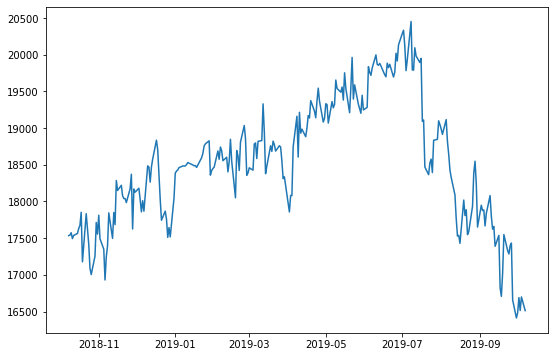

In [58]:
plt.plot(unscaled)
#plt.gridlines(True)
unscaled.head(30)

In [59]:
y_pred = unscaled

print(y_pred)


#y_lower = np.percentile(y_pred, 10)

#print(y_lower)
#y_higher = np.percentile(y_Pred, 90)
#y_mid = np.percentile(y_pred, 50)

ds
2018-10-08    17534.786229
2018-10-09    17541.409862
2018-10-10    17574.645398
2018-10-11    17494.281269
2018-10-12    17537.562706
2018-10-15    17564.122197
2018-10-16    17631.015595
2018-10-17    17674.201332
2018-10-18    17852.590636
2018-10-19    17178.460634
2018-10-22    17834.034937
2018-10-23    17630.692828
2018-10-24    17422.425986
2018-10-25    17090.162540
2018-10-26    17004.528506
2018-10-29    17256.064889
2018-10-30    17714.567286
2018-10-31    17555.436540
2018-11-01    17812.865570
2018-11-02    17492.100374
2018-11-05    17350.381452
2018-11-06    16930.917569
2018-11-07    17245.440200
2018-11-08    17396.596678
2018-11-09    17844.675796
2018-11-12    17497.611747
2018-11-13    17850.273936
2018-11-14    17684.969904
2018-11-15    18285.868714
2018-11-16    18150.118847
                  ...     
2019-08-27    18386.798281
2019-08-28    18548.640353
2019-08-29    18242.916031
2019-08-30    17652.135329
2019-09-02    17949.180479
2019-09-03    17876.24239

In [39]:
# Confidence Interval Time Series From tutorial https://campus.datacamp.com/courses/machine-learning-for-time-series-data-in-python/validating-and-inspecting-time-series-models?ex=12

# Bootstrapping TUtorial Statistics
# https://campus.datacamp.com/courses/statistical-thinking-in-python-part-2/bootstrap-confidence-intervals?ex=5

n_boots = 100

bootstrap_means = np.zeros((n_boots, len(y_pred)))

for ii in range(n_boots):
    # Generate random indices for our data with replacement,
    # then take the sample mean
    random_sample = resample(y_pred)
    bootstrap_means[ii] = random_sample.mean(axis=0)
# Compute the percentiles of choice for the bootstrapped means
percentiles = np.percentile(bootstrap_means, (2.5, 97.5), axis=0)

#conf_int = pd.DataFrame({'2.5%': bootstrap_interval(y_pred)[0], '97.5%': bootstrap_interval(y_pred)[1], 'actual': y_pred})
conf_int = pd.DataFrame({'2.5%': bootstrap_interval(y_pred)[0], '97.5%': bootstrap_interval(y_pred)[1], 'actual': y_pred})


In [44]:
print(bootstrap_means)

[[18456.84378109 18456.84378109 18456.84378109 ... 18456.84378109
  18456.84378109 18456.84378109]
 [18461.94082895 18461.94082895 18461.94082895 ... 18461.94082895
  18461.94082895 18461.94082895]
 [18590.67147797 18590.67147797 18590.67147797 ... 18590.67147797
  18590.67147797 18590.67147797]
 ...
 [18459.25407789 18459.25407789 18459.25407789 ... 18459.25407789
  18459.25407789 18459.25407789]
 [18529.62445989 18529.62445989 18529.62445989 ... 18529.62445989
  18529.62445989 18529.62445989]
 [18570.15957174 18570.15957174 18570.15957174 ... 18570.15957174
  18570.15957174 18570.15957174]]


In [37]:
n_boots = 100

bootstrap_means = np.zeros((n_boots, len(y_pred)))

for ii in range(n_boots):
    # Generate random indices for our data with replacement,
    # then take the sample mean
    random_sample = resample(y_pred)
    bootstrap_means[ii] = random_sample.mean(axis=0)
    print('random sample: ', random_sample)
    print()
    print('calculated mean', random_sample.mean(axis=0))
    print()

random sample:  ds
2018-11-28    17625.593422
2019-02-27    18356.570512
2019-01-29    18358.778301
2019-02-25    19034.772323
2018-12-31    18046.456536
2019-09-20    17549.608819
2018-12-13    18468.833320
2019-07-10    19789.626166
2018-11-29    18170.158469
2019-08-22    17548.826393
2019-05-30    19447.173936
2019-08-21    17887.554343
2019-09-09    18080.648368
2019-03-15    18480.482787
2018-10-11    17494.281269
2019-02-12    18403.477579
2019-02-11    18602.477223
2019-06-28    20132.671710
2018-12-06    18010.799320
2019-03-29    18336.212843
2019-05-02    19321.039420
2019-02-07    18691.143417
2019-06-06    19718.558893
2019-05-23    19395.219011
2019-09-23    17331.690037
2019-04-29    19082.124611
2019-01-25    18784.746840
2019-02-12    18403.477579
2019-02-26    18858.522699
2019-09-16    17538.842278
                  ...     
2019-06-05    19759.973145
2018-11-12    17497.611747
2019-04-17    19170.780500
2019-06-11    19867.582422
2019-09-24    17284.894348
2019-06-2


random sample:  ds
2019-07-12    19982.504484
2019-07-25    18394.101326
2019-04-12    18985.278629
2019-01-15    18497.854885
2019-03-26    18742.749200
2019-03-14    18378.962986
2019-02-19    18694.148427
2019-07-01    20287.408751
2019-07-09    19792.634979
2019-09-30    16413.433836
2019-09-13    17389.691705
2019-08-14    17528.843131
2019-08-16    17430.142103
2019-03-29    18336.212843
2018-12-03    18180.276105
2019-09-12    17660.225321
2018-10-10    17574.645398
2018-11-27    18371.351862
2019-01-29    18358.778301
2019-01-21    18563.399146
2019-07-08    20452.302151
2019-07-29    18847.099827
2019-05-13    19488.879305
2019-07-25    18394.101326
2019-01-04    18461.616093
2018-10-30    17714.567286
2019-04-15    18882.258251
2018-11-08    17396.596678
2018-12-04    18029.378041
2019-07-29    18847.099827
                  ...     
2019-06-04    19836.085132
2019-01-24    18755.643119
2019-09-10    17798.327390
2019-08-05    19115.069366
2018-10-23    17630.692828
2018-10-

In [35]:
bootstrap_means = np.zeros((n_boots, len(y_pred)))
bootstrap_means.shape

(100, 261)

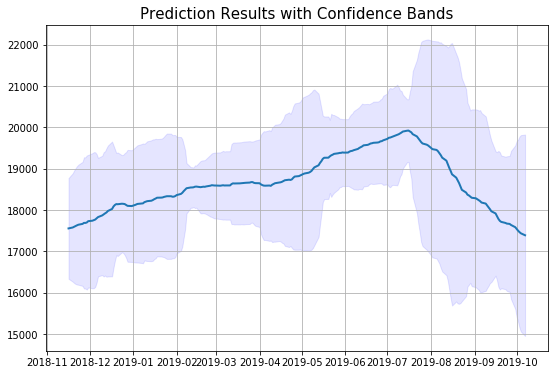

In [25]:
# From https://stackoverflow.com/questions/50161140/how-to-plot-a-time-series-array-with-confidence-intervals-displayed-in-python

time_series_df = pd.DataFrame(y_pred)
smooth_path    = time_series_df.rolling(30).mean()
path_deviation = 2 * time_series_df.rolling(30).std()
plt.plot(smooth_path, linewidth=2)
plt.fill_between(path_deviation.index, (smooth_path-2*path_deviation)[0], (smooth_path+2*path_deviation)[0], color='b', alpha=.1)
plt.grid()
plt.title('Prediction Results with Confidence Bands', fontsize=15)
plt.show()

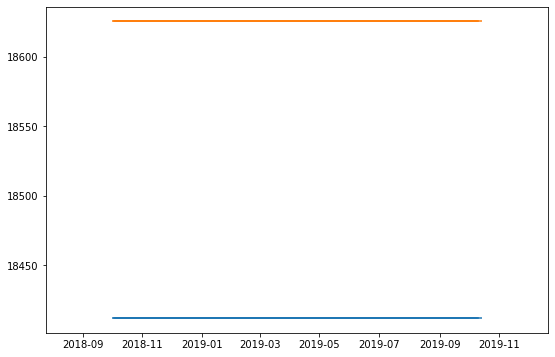

In [27]:
fig, ax = plt.subplots()
ax.scatter(y_pred.index, percentiles[0], marker='_', s=200)
ax.scatter(y_pred.index, percentiles[1], marker='_', s=200)

In [30]:
def my_corrcoef(est, X, y):
    """Return the correlation coefficient
    between model predictions and a validation set."""
    return np.corrcoef(y, est.predict(X))[1, 0]
# Grab the date of the first index of each validation set
first_indices = [data.index[tt[0]] for tr, tt in cv.split(X, y)]
# Calculate the CV scores and convert to a Pandas Series
cv_scores = cross_val_score(model, X, y, cv=cv, scoring=my_corrcoef)
cv_scores = pd.Series(cv_scores, index=first_indices)



fig, axs = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
# Calculate a rolling mean of scores over time
cv_scores_mean = cv_scores.rolling(10, min_periods=1).mean()
cv_scores.plot(ax=axs[0])
axs[0].set(title='Validation scores (correlation)', ylim=[0, 1])
# Plot the raw data
data.plot(ax=axs[1])
axs[1].set(title='Validation data')

NameError: name 'cv' is not defined

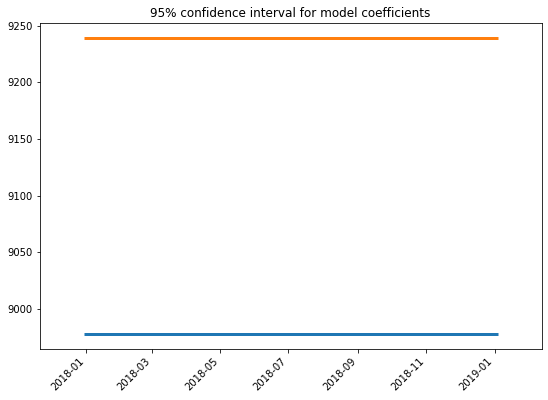

In [93]:
# Calculate a confidence interval around each coefficient
bootstrapped_interval = bootstrap_interval(y_pred)

# Plot it
fig, ax = plt.subplots()
ax.scatter(y_pred.index, bootstrapped_interval[0], marker='_', lw=3)
ax.scatter(y_pred.index, bootstrapped_interval[1], marker='_', lw=3)
ax.set(title='95% confidence interval for model coefficients')
plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

In [ ]:
y_pred

for i in range(100)

In [ ]:
# bootstrap for mean
boot_means = []
for _ in range(100):
    bootsample = np.random.choice(sample,size=30, replace=True)
    boot_means.append(bootsample.mean())